# Load data

In [1]:
#from structure_and_load import load
import os
import scipy.io as sio 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [ ]:
b

In [2]:
def open_matlab_file(path):
    """
    Open a matlab behaviour structure from OrganizeBehaviour and save it in a python dictionary. One
    SESSION corresponds to one behavioural file - independently of the number of probes.
    :param filename: name of the matlab structure containing the behavioural information
    :return: behaviour: dictionary containing the same fields as the behaviour structure from matlab
    """
    # initialize a counter for the number of files loaded
    n_file = -1
    # get filenames in list in the session directory
    filenames = os.listdir(path)

    data = [] 
    load_info = []
    
    # Loop through MATLAB files in the session directory
    for matfile in filenames:

        n_file += 1  
        print(f'loading {matfile}')
        load_info.append((n_file, matfile))

        # get the full file path for the current file and load MATLAB file
        filepath = os.path.join(path, matfile) 
        matfile = sio.loadmat(filepath)

        # get the name of the sub-structure within the MATLAB file
        data_str_name = list(matfile.keys())[-1]

        # get the field names within the sub-structure and use them as keys for the new dictionary
        fields = []
        for key in matfile[data_str_name].dtype.fields.keys():
            fields.append(key)

        # Extract the data inside the sub-structure and save dictionnary in list
        data_ = matfile[data_str_name][0][0]
        data.append({field: data_[i_field][:, 0] for i_field, field in enumerate(fields)})
        

    print(f'\n{n_file + 1} files loaded')
    
    return data, load_info

In [3]:
session = 't150204001'
data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'
#load data
data, load_info = open_matlab_file(data_path)

loading t150204001_probe1_contact6_unit1.mat
loading t150204001_probe2_contact24_unit1.mat
loading t150204001_probe1_contact19_unit1.mat
loading t150204001_probe1_contact17_unit1.mat
loading t150204001_probe1_contact12_unit1.mat
loading t150204001_probe2_contact7_unit4.mat
loading t150204001_probe2_contact14_unit1.mat
loading t150204001_probe2_contact9_unit3.mat
loading t150204001_probe1_contact1_unit1.mat
loading t150204001_probe2_contact23_unit1.mat
loading t150204001_probe2_contact19_unit1.mat
loading t150204001_probe2_contact8_unit1.mat
loading t150204001_probe2_contact21_unit1.mat
loading t150204001_probe1_contact5_unit1.mat
loading t150204001_probe1_contact13_unit1.mat
loading t150204001_probe2_contact10_unit1.mat
loading t150204001_probe2_contact9_unit1.mat
loading t150204001_probe1_contact11_unit3.mat
loading t150204001_probe1_contact4_unit1.mat
loading t150204001_probe2_contact5_unit1.mat
loading t150204001_probe2_contact18_unit1.mat
loading t150204001_probe2_contact2_unit1.ma

# Stucture

## info session / units

In [4]:
import re
df = pd.read_excel(info_path)
df.dropna(how='all', inplace=True)
df.drop(columns=['BehDir', 'pitch', 'A/P', 'Lat', 'depth', 'SNR', 'Unnamed: 14', 'depth (no buffer)'], inplace=True)
df.rename(columns={'%Plexon_spike_file' : 'Plexon_spike_file'}, inplace=True)
float_column_names = df.select_dtypes(include=['float']).columns
df[float_column_names] = df[float_column_names].astype(int)

In [5]:
list_prob = []
list_chan = []
list_unit = []

info_units = []

for i in range(len(load_info)) :
    matfile = load_info[i][1]
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', matfile)
    match_contact = re.search(r'contact(\d+)', matfile)
    match_unit = re.search(r'unit(\d+)', matfile)

    info_units.append({
        'probe':int(match_probe.group(1)), 
        'contact':int(match_contact.group(1)), 
        'unit':int(match_unit.group(1))})


    list_prob.append(int(match_probe.group(1)))
    list_chan.append(int(match_contact.group(1)))
    list_unit.append(int(match_unit.group(1)))

#info_units = pd.DataFrame(info_units)
sub_info_session = df[df['Plexon_spike_file'].str.startswith(f'{session}')]


info_session = pd.DataFrame()
list_idx = []
for i in range(len(list_unit)):
    sub_data = sub_info_session[(sub_info_session['probe'] == list_prob[i]) & (sub_info_session['channel'] == list_chan[i]) & (sub_info_session['unit'] == list_unit[i])]
    list_idx.append(sub_data.index[0])
    info_session = pd.concat((info_session, sub_data))

In [6]:
def convert_elitrials(entry):
    if pd.notna(entry):  # Check for NaN
        # Remove square brackets and split by space to separate pairs
        pairs = entry.replace('[', '').replace(']', '').split()
        result = []
        for pair in pairs:
            start, end = map(int, pair.split(':'))
            result.append([start, end])
        return result
    else:
        return None
        
info_session['elitrials'] = info_session['elitrials'].apply(convert_elitrials)

In [7]:
info_session

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
162,t150204001_chan_01_24_new,1,6,1,8,11,1,"[[123, 128]]"
208,t150204001_chan_25_48_new,2,24,1,5,8,1,"[[129, 139]]"
177,t150204001_chan_01_24_new,1,19,1,1,8,1,None
175,t150204001_chan_01_24_new,1,17,1,1,3,1,None
170,t150204001_chan_01_24_new,1,12,1,1,3,1,None
189,t150204001_chan_25_48_new,2,7,4,8,10,1,"[[123, 128], [170, 173]]"
197,t150204001_chan_25_48_new,2,14,1,3,5,1,None
192,t150204001_chan_25_48_new,2,9,3,1,8,1,None
156,t150204001_chan_01_24_new,1,1,1,5,8,1,"[[132, 139]]"
206,t150204001_chan_25_48_new,2,23,1,1,3,1,None


In [8]:
first_bloc = info_session['start'].min()
last_bloc = info_session['stop'].max()

print(f'start / stop:\n   {first_bloc} /   {last_bloc}')

tasktime = info_session[(info_session['start'] == first_bloc) & (info_session['stop'] == last_bloc) & (info_session['elitrials'].isna())]
tasktimeComplete = tasktime.shape[0] != 0

if tasktimeComplete :
    unit_info = tasktime[['probe', 'channel', 'unit']].values[0]
    print(f"{tasktime[['start', 'stop', 'elitrials']]} \n\nunit_info : {unit_info}")
    matfile = f'{session}_probe{unit_info[0]}_contact{unit_info[1]}_unit{unit_info[2]}.mat'

    for i in load_info:
        if i[1] == matfile:
            completeUnit = i[0]
            print(f"{i[1]}\n\nunit's loading index = {completeUnit}")

else :
    print('ANY UNIT RECORDED OVER ENTIRE SESSION') 
    print(f"check here to construct session times by hand :\n {info_session['start'] == first_bloc}")

tasktime

start / stop:
   1 /   11
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 32


,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
159,t150204001_chan_01_24_new,1,3,1,1,11,1,None


# Exctract data

In [9]:
# get spike train / periodes times / target info
spike_times = []
task_data = []
target_info = []
target_keys = ['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type']
event_keys_OFF = ['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF']


for unit_idx in range(len(data)):
    spike_times.append((load_info[unit_idx], data[unit_idx]['ts']))  

    # List of keys to extract (excluding 'ts', cues direction and times OFF to be constistent with previous results)
    times_keys = [key for key in data[unit_idx] if key != 'ts' and key not in target_keys and key not in event_keys_OFF]
    task_info = {}
    for key_time in times_keys :
        task_info[key_time] = data[unit_idx][key_time]
    task_data.append((load_info[unit_idx],task_info))

    target_ = {}
    for key_target in target_keys :
        target_[key_target] = data[unit_idx][key_target]
    target_info.append((load_info[unit_idx], target_))

    event_labels = list(task_data[0][1].keys())


print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')

spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


# Time formating

In [10]:
# get event times by trial for each neuron
def events(task_data):
    """
    Retrieves event times from task data file sorts them for each unit

    Args:
    - task_data (list): List of tuples where each tuple contains file information and a dictionary of task-related data.

    Returns:
    - event_times (list of numpy.ndarray): List of arrays containing event times.

    Example usage:
    - event_labels, event_times, event_times_vector = event_times(task_data)
    """

    # Get event times by event labels
    event_times = []
    for unit_idx in range(len(task_data)):
        times = []
        for event in event_labels:
            times.append(task_data[unit_idx][1][event])
        event_times.append((task_data[unit_idx][0], np.array(times, dtype=object)))

    return event_times

event_times = events(task_data)

In [11]:
# reshape times by trials / periods for each neuron + Neo format
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

def events_by_trial(event_times, event_labels):
    '''
    Structure periods timestamps by trial and store in a data frame.

    Args:
    - event_times (numpy.ndarray): Array of event times where rows represent events, and columns represent trials.
    - event_labels (list): List of event labels corresponding to the columns of the data frame.

    Returns:
    - trials_ts (list of numpy.ndarray): List of event times structured by trial.
    - df_task_ts (list of pandas.DataFrame): List of data frames containing event times structured by trial.
    - events (list of list): List of Event objects.

    '''
    trials_ts = []  # List to store event times structured by trial
    df_task_ts_by_neuron = []  # List to store data frames containing event times structured by trial
    events = []  # List to store Event objects

    for unit_idx in range(len(event_times)):
        n_events = event_times[unit_idx][1].shape[0]
        n_trials = event_times[unit_idx][1].shape[1]

        events_ts = np.zeros((n_trials, n_events), dtype=int)
        event_list = []

        # Split time stamps for each period according to the trial
        for trial in range(n_trials):
            for event in range(n_events):
                events_ts[trial][event] = event_times[unit_idx][1][event][trial]
            
            event_list.append(Event(events_ts[trial] * ms, labels=event_labels, dtype='U'))

        events.append((event_times[unit_idx][0], event_list))
        trials_ts.append((event_times[unit_idx][0], events_ts))
        task_ts = pd.DataFrame(events_ts, columns=event_labels)
        df_task_ts_by_neuron.append((event_times[unit_idx][0], task_ts))

    return trials_ts, df_task_ts_by_neuron, events

trials_ts, df_task_ts_by_neuron, events = events_by_trial(event_times, event_labels)

unit_ = 6
trial_ = 0
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
df_task_ts_by_neuron[unit_][1].head()

times as list : [1026429 1027493 1028801 1030123 1031431 1032716 1033250]
times as neo events : [1026429. 1027493. 1028801. 1030123. 1031431. 1032716. 1033250.] ms


,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,1026429,1027493,1028801,1030123,1031431,1032716,1033250
1,1035281,1036357,1037665,1038974,1040282,1041567,1042151
2,1108631,1109726,1111034,1112343,1113651,1114936,1115725
3,1129500,1130605,1131913,1133222,1134546,1135842,1136375
4,1139902,1140978,1142286,1143594,1144902,1146190,1146777


# Compute

In [12]:
total_trial_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, total_trial_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


## units labels

In [13]:
info_units_df = pd.DataFrame(info_units)
count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))

n_units = len(spike_times)
n_event = event_labels[:-1]

unit_label = []
unit_labelProbe1 = []
unit_labelProbe2 = []

for i in range(n_units):
    label = str(\
        'P' + str(info_units[i]['probe']) \
        + '-' + str(info_units[i]['contact']) \
        + '-' + str(info_units[i]['unit'])) 
    unit_label.append(label)

    if info_units[i]['probe'] == 1 :
        unit_labelProbe1.append(label)
    else : 
        unit_labelProbe2.append(label)

print(len(unit_labelProbe1) == count_unitProbe[0])
print(len(unit_labelProbe2) == count_unitProbe[1])
unit_labelTwoprobes = unit_label

True
True


#  Trials ref 

In [14]:
n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

In [15]:
for unit in range(n_units) :
    list_idx_trial = []
    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials_unit = times_unit.shape[0]

    for trial in range(n_trials_unit):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)


# Spike times formating (alignement, nan for invalid trials)

In [16]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_ts_trial(n_neurons, trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []
    

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
                # fill the matrice with spike times aligned to 0
                spike_train[unit_idx].append(spk_ts_trial)

    return spk_trials, spike_train
    

spk_trials, spike_train_trial = spike_ts_trial(n_neurons, trials_ts, spike_times)

In [17]:
'''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

def align_trials(df_task_ts, df_task_ts_by_neuron, spike_times):
    n_units = len(spike_times)

    for unit_idx in range(n_units):
        data = df_task_ts_by_neuron[unit_idx][1]
        list_trials_unit = list(data['idx_ref_trial'])

        nan_trials = [item for item in list_trials_task if item not in list_trials_unit]
        valid_trials = [item for item in list_trials_task if item in list_trials_unit]

        for idx_trial_valid, trial_valid in enumerate(valid_trials):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial_valid][1]
            t_stop = data.loc[idx_trial_valid][-1]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            spikes_times_aligned_ = []
                    
            for spk_idx, spk in enumerate(spk_tmp[sel_spk]):
                spk_aligned = spk - t_start
                spikes_times_aligned_.append(spk_aligned)
                        
            spikes_times_aligned[unit_idx][trial_valid]= {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : trial_valid, 
                        't_start' : t_start - t_start,
                        't_stop': t_stop - t_start,
                        'spike_time' : np.array(spikes_times_aligned_), 
                        'spike_train' : spike_train_trial[unit_idx][idx_trial_valid]
                        }

        for idx_trial_nan in (nan_trials):
            t_start_nan = df_task_ts.loc[idx_trial_nan][0]
            t_stop_nan = df_task_ts.loc[idx_trial_nan][-1]


            spikes_times_aligned[unit_idx][idx_trial_nan] = {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : idx_trial_nan, 
                        't_start' : t_start_nan - t_start_nan,
                        't_stop': t_stop_nan - t_start_nan,
                        'spike_time' : np.zeros(1, dtype=np.int64),
                        'spike_train' :  np.zeros(1, dtype=np.int64)
                        }

    return spikes_times_aligned
    
list_trials_task = list(df_task_ts.index)
spikes_times_aligned = np.zeros((n_neurons, n_trials), dtype=object)
spikes_times_aligned = align_trials(df_task_ts, df_task_ts_by_neuron, spike_times)


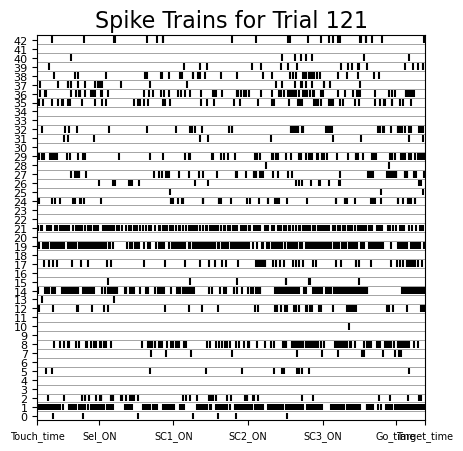

In [18]:
t = 121
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(5, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# ISI Draft

## For one Trial

def compute_isi(x, y):
    x_isi = np.diff(x)
    y_isi = np.diff(y)

    return x_isi, y_isi

n_neurons_ = 2 
n_trials_ = 1
n_times = spikes_times_aligned[n][121]['t_stop']

for n in range(2 - 1):
    spiketrain1 = spikes_times_aligned[n][121]['spike_time']
    spiketrain2 = spikes_times_aligned[n+1][121]['spike_time']

    x_isi, y_isi = compute_isi(spiketrain1, spiketrain2)
    #time = np.zeros(spikes_times_aligned[n][121]['t_stop'])
    x_isi_in_time = np.zeros(n_times)
    y_isi_in_time = np.zeros(n_times)

    for ts_idx, ts in enumerate(spiketrain1[:-1]): 
        x_isi_in_time[ts : ts + x_isi[ts_idx]] = x_isi[ts_idx]

    for ts_idx, ts in enumerate(spiketrain2[:-1]): 
        y_isi_in_time[ts : ts + y_isi[ts_idx]] = y_isi[ts_idx]


    I_isi = np.zeros(n_times)

    for t in range(n_times) :
        x_t = x_isi_in_time[t]
        y_t = y_isi_in_time[t]

        if x_t == 0 and y_t == 0:
            I_isi[t] =  0  

        elif x_t == 0 and y_t > 0: 
            I_isi[t] =  -1

        elif x_t > 0 and y_t == 0: 
            I_isi[t] =  1

        elif x_t <= y_t :
            I_isi[t] =  x_t / y_t - 1

        else:
            I_isi[t] = - (y_t / x_t - 1) 
        


print(spiketrain1)
print(x_isi)
plt.figure()
plt.plot(x_isi_in_time)
plt.plot(y_isi_in_time)
plt.figure()
plt.plot(I_isi)
plt.ylim(-1.1, 1.1)

## For two trials 

mask_tri = np.tri(n_units, n_units, -1, dtype=bool)

neuron1 = np.repeat(np.arange(n_units).reshape([-1,1]), n_units, axis=1)
neuron2 = np.repeat(np.arange(n_units).reshape([1,-1]), n_units, axis=0)

neuron1 = neuron1[mask_tri]
neuron2 = neuron2[mask_tri]

for unit in range(len(neuron1)) :
    n1 = neuron1[unit]
    n2 = neuron2[unit]

I_isi = np.zeros((n_trials, n_units, n_units), dtype=object)

for t in range(2):
    print(f'trial : {t}')
    n_times = spikes_times_aligned[0][t]['t_stop']
    i_isi = np.zeros((n_units, n_units, n_times))

    for n1 in range(n_units):
        print(f'neurone 1 : {n1}')
        spiketrain1 = spikes_times_aligned[n1][t]['spike_time']
        
        for n2 in range(n_units):
            spiketrain2 = spikes_times_aligned[n2][t]['spike_time']

            x_isi, y_isi = compute_isi(spiketrain1, spiketrain2)
            #time = np.zeros(spikes_times_aligned[n][121]['t_stop'])
            x_isi_in_time, y_isi_in_time = np.zeros(n_times), np.zeros(n_times)

            for ts_idx, ts in enumerate(spiketrain1[:-1]): 
                x_isi_in_time[ts : ts + x_isi[ts_idx]] = x_isi[ts_idx]

            for ts_idx, ts in enumerate(spiketrain2[:-1]): 
                y_isi_in_time[ts : ts + y_isi[ts_idx]] = y_isi[ts_idx]


            for time in range(n_times) :
                x_t = x_isi_in_time[time]
                y_t = y_isi_in_time[time]

                if x_t == 0 and y_t == 0:
                    i_isi[n1, n2, time] =  0  

                elif x_t == 0 and y_t > 0: 
                     i_isi[n1, n2, time] =  -1

                elif x_t > 0 and y_t == 0: 
                     i_isi[n1, n2, time] =  1

                elif x_t <= y_t :
                    i_isi[n1, n2, time] =  x_t / y_t - 1

                else:
                     i_isi[n1, n2, time] = - (y_t / x_t - 1) 
                

            I_isi[t, n1, n2] = i_isi[n1, n2, :]


# ISI updated 

In [19]:
from synchrony import ISI

In [20]:
row, col = np.triu_indices(n_units, k=1)
n_pairs = len(row)
ISI_distance = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop']
    ISI_tmp = np.zeros((n_units, n_times))
    for n in range(n_units) :
        isi = ISI.compute(spikes_times_aligned[n][t]) 
        ISI_tmp[n, :] = isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(ISI_tmp[r, :], ISI_tmp[c, :])
    
    ISI_distance.append(ISI_distance_one_trials)

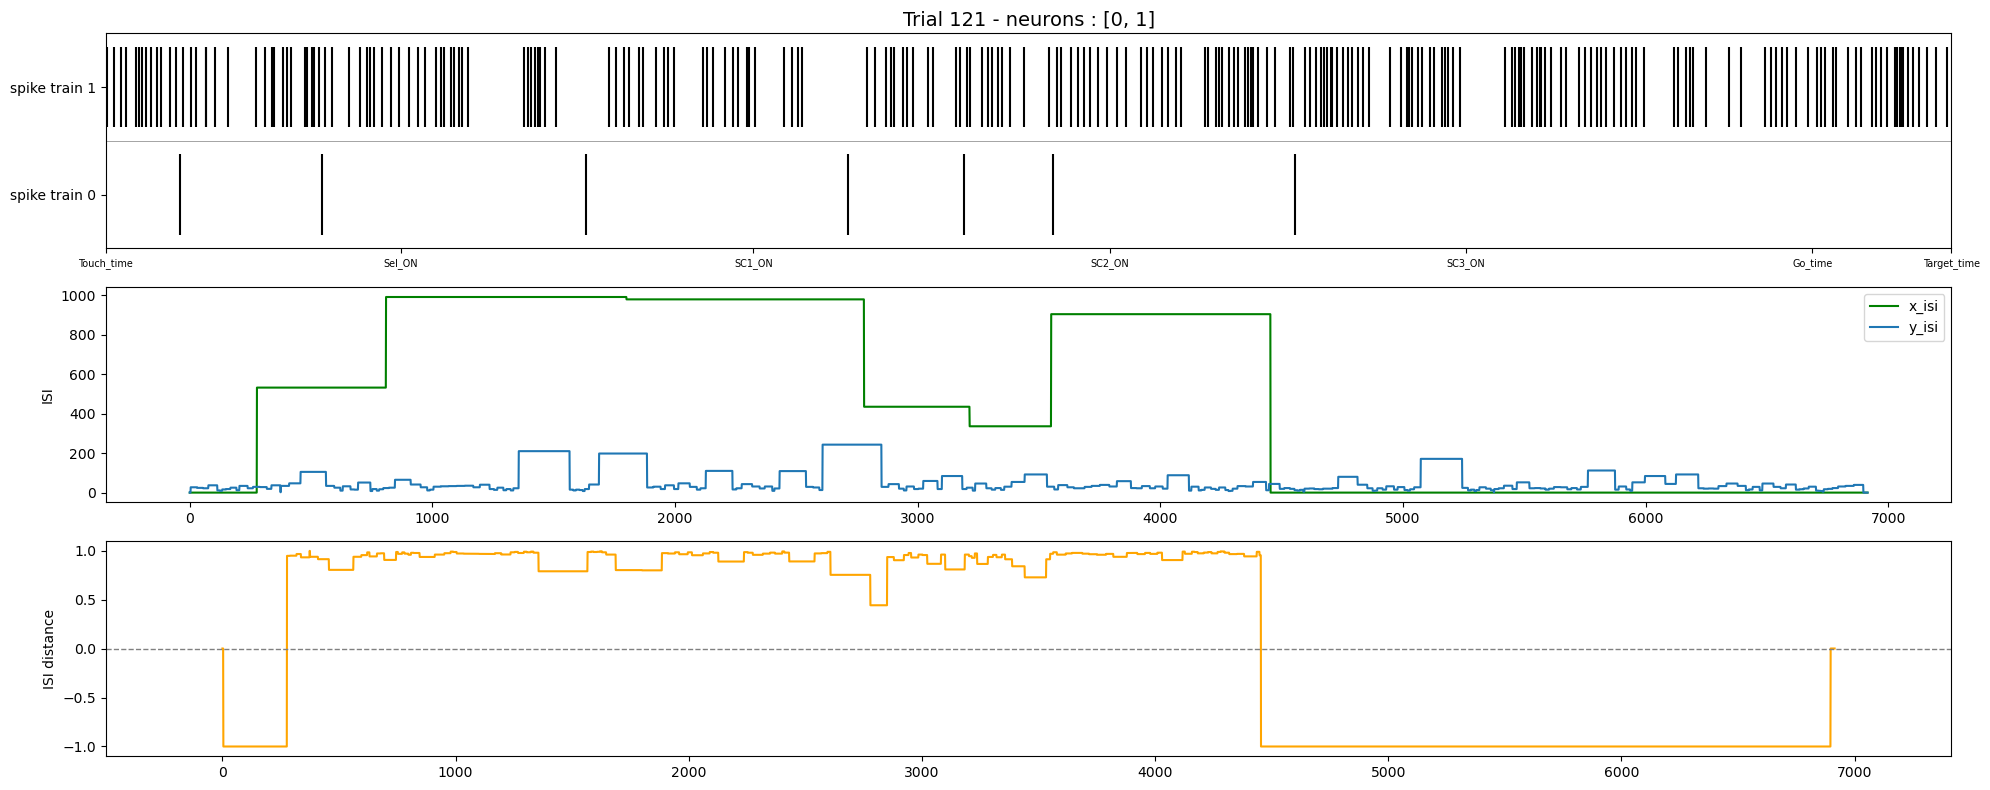

In [21]:
t = 121
neurons_ = [0,1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for n in neurons_ : 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {i}" for i in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

In [22]:
neurons_[0]

0

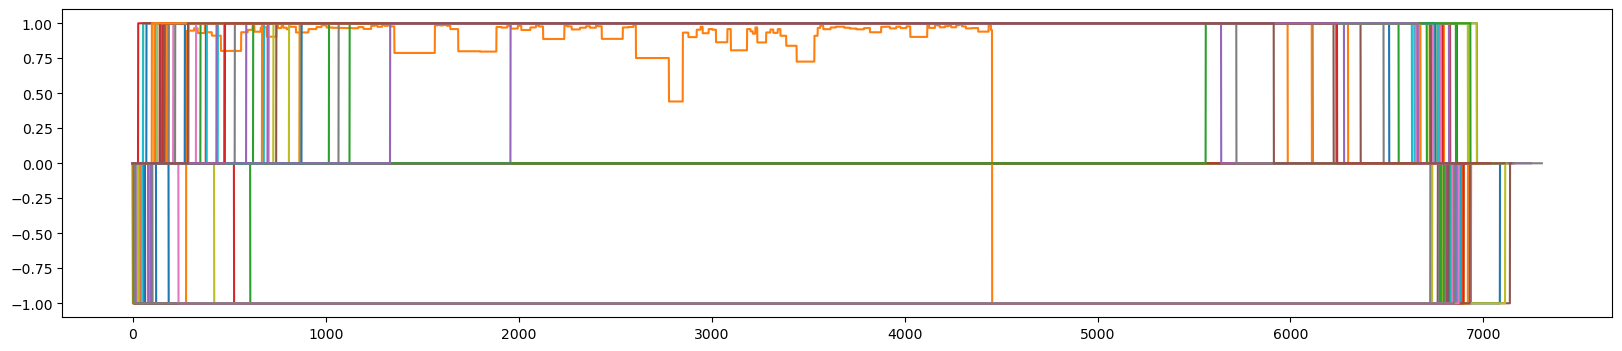

In [23]:
plt.figure(figsize=(20, 4))
for t in range(n_trials):
  x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[neurons_[0]]][t])
  y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[neurons_[1]]][t]) 
  ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)
  plt.plot(ISI_distance_)   

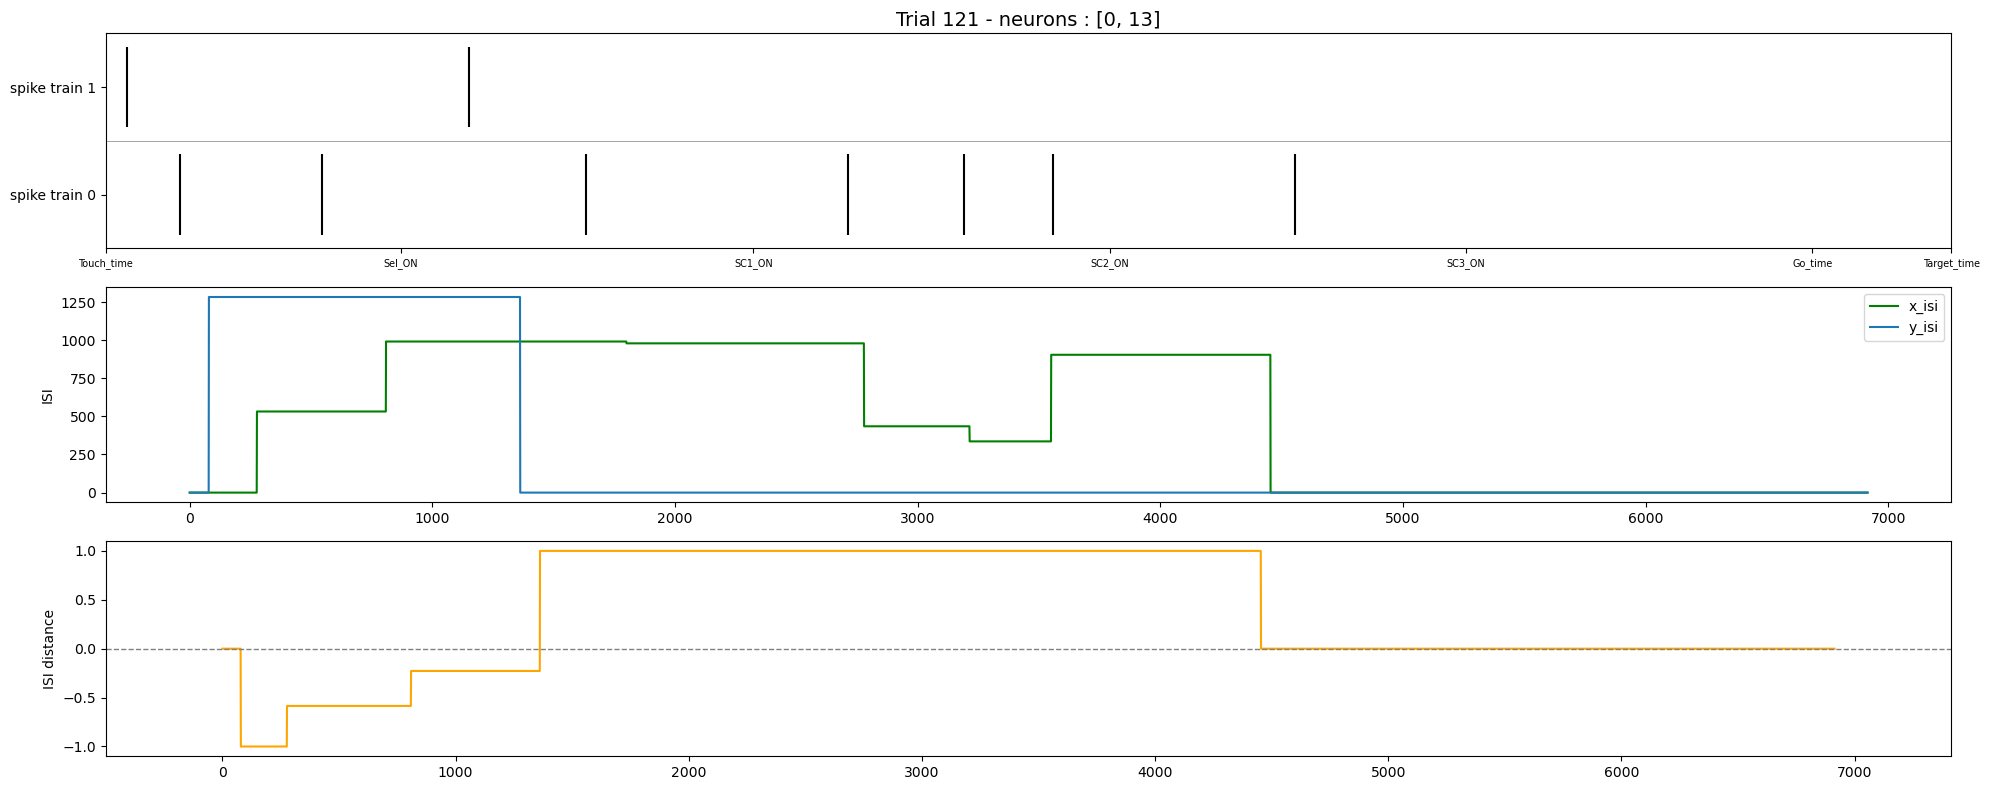

In [24]:
t = 121
neurons_ = [0,13]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

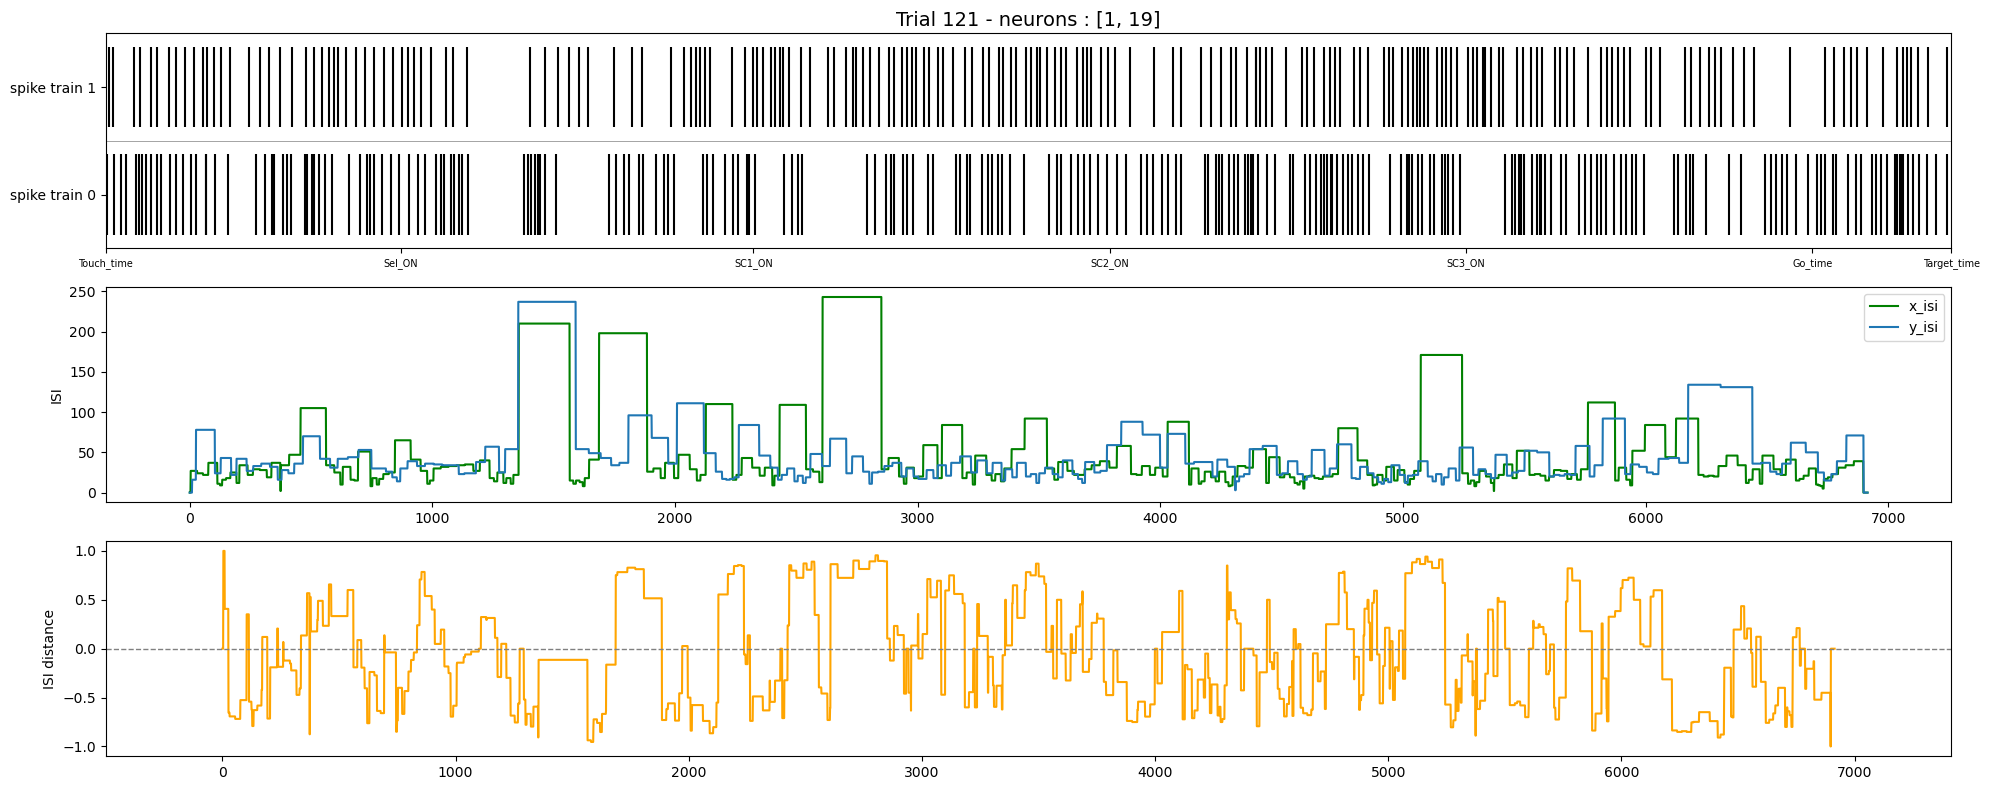

In [25]:
t = 121
neurons_ = [1,19]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

# ISI Mean across trials 

In [26]:
def get_max_length(n_trials, ISI_distance):
    time_ = np.zeros((n_trials), dtype=int)
    for t in range(n_trials): 
        time_[t] = ISI_distance[t].shape[1]
    max_length = np.max(time_)

    return max_length

In [27]:
def interpolate_ISI_distance(ISI_distance, max_length):
    len_trial = ISI_distance.shape[0]
    ISI_distance_interp_ = np.full(max_length, np.nan)
    ISI_distance_interp_[:len_trial] = ISI_distance
    return ISI_distance_interp_

In [28]:
max_length = get_max_length(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)

In [29]:
for n in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[n, :, p] = interpolate_ISI_distance(ISI_distance[n][p], max_length)

In [ ]:
np.where(np.isnan(ISI_distance_mean) == True)

(array([6915, 6916, 6917, ..., 7997, 7998, 7999]),)

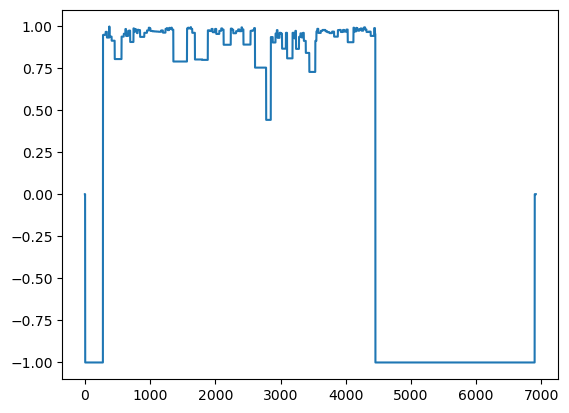

In [ ]:
plt.plot(ISI_distance_mean)

 ...]

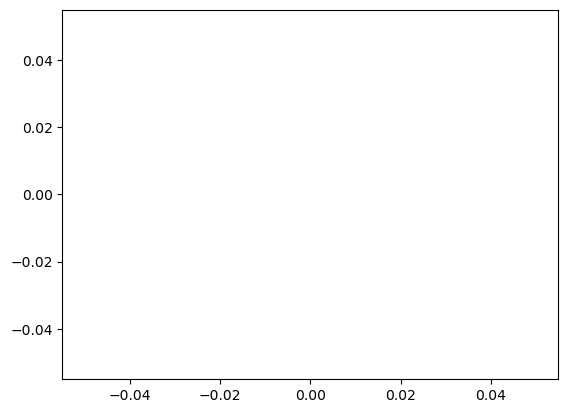

In [ ]:
plt.plot(ISI_distance_mean)

In [ ]:
for p in range(n_pairs) :
    len_trial = ISI_distance[t].shape[1]
    ISI_distance_mean[t, :len_trial] =  ISI_distance[t][:, :]

#nan_array[:len(vec2)] = vec2

TypeError: 'float' object is not callable

In [ ]:
ISI_distance[0][:].shape

(903, 6923)

In [ ]:
ISI_distance_interp = np.zeros((n_trials,n_pairs, max_lenght))

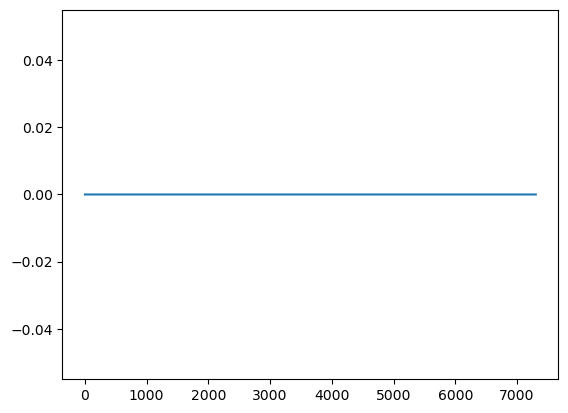

In [ ]:
ISI_distance_interp.shape
plt.plot(ISI_distance_interp[0][121])

In [ ]:
ISI_distance_interp = ISI_distance

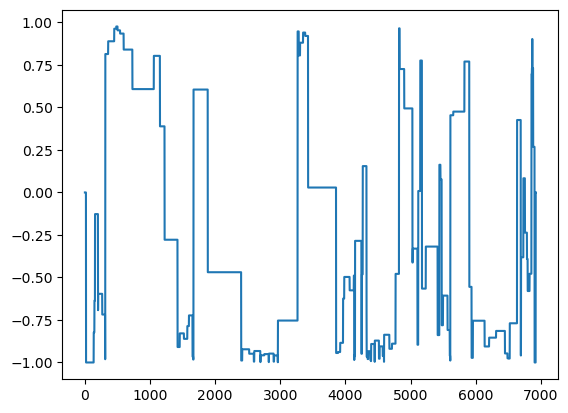

In [ ]:
plt.plot(ISI_distance_interp[0][121])

In [ ]:
# Check for NaN values
nan_mask = np.isnan(ISI_distance_interp[0][121])

# Count the number of NaN values
num_nan = np.sum(nan_mask)

# Print the result
if num_nan > 0:
    print("There are NaN values in the array.")
    print("Number of NaN values:", num_nan)
else:
    print("There are no NaN values in the array.")

There are no NaN values in the array.


In [ ]:
ISI_distance_interp[0][121].shape

(6923,)

In [ ]:
ISI_distance[0][121].shape

(6923,)